AInewsbot.ipynb

- Open URLs of news sites specififed in `sources` dict using Selenium and Firefox
- Save HTML of each URL in htmldata directory
- Extract URLs from all files, create a pandas dataframe with url, title, src
- Use ChatGPT to filter only AI-related headlines by sending a prompt and formatted table of headlines
- Use SQLite to filter headlines previously seen 
- OPENAI_API_KEY should be in the environment or in a .env file
  
Alternative manual workflow to get HTML files if necessary
- Use Chrome, open e.g. Tech News bookmark folder, right-click and open all bookmarks in new window
- on Google News, make sure switch to AI tab
- on Google News, Feedly, Reddit, scroll to additional pages as desired
- Use SingleFile extension, 'save all tabs'
- Move files to htmldata directory
- Run lower part of notebook to process the data


In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# use firefox because it updates less often, can disable updates
# recommend importing profile from Chrome for cookies, passwords
# looks less like a bot with more user cruft in the profile
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service

import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

import openai
from openai import OpenAI
import tiktoken

import dotenv
import pandas as pd
import sqlite3

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"openai          {openai.__version__}")
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

openai          1.14.2
requests        2.31.0
BeautifulSoup   4.12.3


In [ ]:
print(datetime.now())

In [2]:
# load credentials if necessary
dotenv.load_dotenv()
client = OpenAI()

In [3]:
# delete files in output directory
download_dir = "htmldata"

def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')


delete_files(download_dir)

# Specify sources

In [4]:
sources = {
    # "Twitter": {
    #     "title": "@TheLinkfest_AI _ X",
    #     "include": ["^https://twitter.com/(\w+)/status/(\d+)$"],
    # },
    "Reddit": {
        "title": "top scoring links _ multi",
        "url": "https://www.reddit.com/r/ChatGPT+ChatGPTCoding+MacOS+MachineLearning+OpenAI+ProgrammerHumor+Windows10+battlestations+buildapc+cordcutters+dataisbeautiful+gadgets+hardware+linux+msp+programming+realtech+software+talesfromtechsupport+tech+technews+technology+techsupportgore+windows/top/?sort=top&t=day",
        "scroll": 2,
        "exclude": [
            "^https://www.reddit.com/",
            "^https://chat.reddit.com/",
            "^https://i.redd.it/",
            "^https://redditblog.com/",
            "^https://www.redditinc.com/",
            "^https://www.reddithelp.com/",
            "^https://itunes.apple.com/",
            "^https://play.google.com/",
        ],
    },
    "Hacker News": {
        "title": "Hacker News Page 1",
        "url": "https://news.ycombinator.com/",
        "exclude": [
            "https://news.ycombinator.com/",
            "https://www.ycombinator.com/",
        ],
    },
    "Hacker News 2": {
        "title": "Hacker News Page 2",
        "url": "https://news.ycombinator.com/?p=2",
        "exclude": [
            "https://news.ycombinator.com/",
            "https://www.ycombinator.com/",
        ],
    },
    "Techmeme": {
        "title": "Techmeme",
        "url": "https://www.techmeme.com/river",
        "exclude": [
            "^https://www.techmeme.com",
            "^https://twitter.com/",
            "^https://www.threads.net",
            "^https://www.linkedin.com",
            "^https://mastodon.social",
            "^https://bsky.app",
        ],
    },
    "Feedly AI": {
        "title": "Discover and Add New Feedly AI Feeds",
        "url": "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ",
        "scroll": 2,
    },
    "NYT Tech": {
        "title": "Technology - The New York Times",
        "url": "https://www.nytimes.com/section/technology",
        "include": ["^https://www.nytimes.com/(\d+)/(\d+)/(\d+)(.*).html$"],
    },
    "WSJ Tech": {
        "title": "Technology - WSJ.com",
        "url": "https://www.wsj.com/tech",
        "include": ["^https://www.wsj.com/articles/"],
    },
    "Bloomberg Tech": {
        "title": "Bloomberg Technology - Bloomberg",
        "url": "https://www.bloomberg.com/technology",
        "include": ["^https://www.bloomberg.com/news/(\w+)/(\d+)-(\d+)-(\d+)"],
    },
    "FT Tech": {
        "title": "Technology",
        "url": "https://www.ft.com/technology",
        "include": ["https://www.ft.com/content/"]
    },
    "WaPo Tech": {
        "title": "Technology - The Washington Post",
        "url": "https://www.washingtonpost.com/business/technology/",
        "include": ["https://www.washingtonpost.com/(\w+)/(\d+)/(\d+)/(\d+)/"],
    },
    "Google News": {
        "title": "Google News - Technology - Artificial intelligence",
        "url": "https://news.google.com/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGRqTVhZU0FtVnVHZ0pWVXlnQVAB?hl=en-US&gl=US&ceid=US%3Aen",
        "scroll": 2,
        "click" : '//*[@aria-label="Artificial intelligence"]',
        "include": ["^https://news.google.com/articles/"],
    },
    "HackerNoon": {
        "title": "HackerNoon - read, write and learn about any technology",
        "url": "https://hackernoon.com/",
        "include": ["^https://hackernoon.com/([^/])*$"],
        "exclude": [
            "^https://hackernoon.com/$",
            "^https://hackernoon.com/c$",
            "^https://hackernoon.com/coins$",
            "^https://hackernoon.com/companies$",
            "^https://hackernoon.com/gallery$",
            "^https://hackernoon.com/how-to-gain-followers-and-newsletter-subs-directly-on-hackernoon$",
            "^https://hackernoon.com/login$",
            "^https://hackernoon.com/reader-boot$",
            "^https://hackernoon.com/sitemap.xml$",
            "^https://hackernoon.com/startups$",
            "^https://hackernoon.com/techbeat$",
            "^https://hackernoon.com/why-i-write-on-hacker-noon-nl28335q$",
            "^https://hackernoon.com/writer-signup$",
        ],
    },
    "Ars Technica": {
        "title": "Ars Technica",
        "url": "https://arstechnica.com/",
        "include": ["^https://arstechnica.com/gadgets/(\d+)/(\d+)/"],
    },
    "The Register": {
        "title": "The Register_ Enterprise Technology News and Analysis",
        "url": "https://www.theregister.com/",
        "include": ["^https://www.theregister.com/(\d+)/(\d+)/(\d+)/"],
    },
    "Business Insider": {
        "title": "Tech - Business Insider",
        "url": "https://www.businessinsider.com/tech",
        "exclude": ["^https://www.insider.com", "^https://www.passionfroot.me"],
    },
}

sources_reverse = {v["title"]: k for k, v in sources.items()}


# Download HTML files from sources

In [5]:
# download files via selenium and firefox
outputdir = "htmldata"
delete_files(outputdir)

# Print the formatted time
print(datetime.now().strftime('%H:%M:%S'), "Starting", flush=True)

firefox_app_path = '/Applications/Firefox.app'
# Path to your geckodriver
geckodriver_path = '/Users/drucev/webdrivers/geckodriver'

# Set up Firefox options to use your existing profile
# important for some sites that need a login, also a generic profile fingerprint that looks like a bot might get blocked
firefox_profile_path = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'
options = Options()
options.profile = firefox_profile_path

print(datetime.now().strftime('%H:%M:%S'), "Initialized profile", flush=True)

# Create a Service object with the path
service = Service(geckodriver_path)

print(datetime.now().strftime('%H:%M:%S'), "Initialized service", flush=True)
# Set up the Firefox driver
driver = webdriver.Firefox(service=service, options=options)

print(datetime.now().strftime('%H:%M:%S'), "Initialized webdriver", flush=True)
sleeptime = 10

for sourcename, sourcedict in sources.items():
    print(datetime.now().strftime('%H:%M:%S'), f'Processing {sourcename}', flush=True)
    title = sourcedict["title"]
    url = sourcedict["url"]
    scroll = sourcedict.get("scroll", 0)
    click = sourcedict.get("click")

    # Open the page
    driver.get(url)

    # Wait for the page to load
    time.sleep(sleeptime)  # Adjust the sleep time as necessary

    if click:
        print(datetime.now().strftime('%H:%M:%S'), f"Clicking on {click}", flush=True)
        button = driver.find_element(By.XPATH, click)
        if button:
            button.click()
            print(datetime.now().strftime('%H:%M:%S'), f"Clicked", flush=True)

    for _ in range(scroll):
        # scroll to bottom of infinite scrolling window
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        print(datetime.now().strftime('%H:%M:%S'), "Loading additional infinite scroll items", flush=True)
        time.sleep(sleeptime) # wait for it to load additional items

    # Get the HTML source of the page
    html_source = driver.page_source

    # check encoding, default utf-8
    encoding = "utf-8"  # Default to UTF-8 if not specified
    # Retrieve the content-type meta tag from the HTML
    try:
        meta_tag = driver.find_element(By.XPATH, "//meta[@http-equiv='Content-Type']")
        content_type = meta_tag.get_attribute("content")
        # Typical format is "text/html; charset=UTF-8"
        charset_start = content_type.find("charset=")
        if charset_start != -1:
            encoding = content_type[charset_start + 8:]
    except Exception as err:
        pass

    # Save the HTML to a local file
    datestr = datetime.now().strftime("%m_%d_%Y %I_%M_%S %p")
    outfile = f'{title} ({datestr}).html'
    print(datetime.now().strftime('%H:%M:%S'), f"Saving {outfile} as {encoding}", flush=True)
    with open(outputdir + "/" + outfile, 'w', encoding=encoding) as file:
        file.write(html_source)

# Close the browser
driver.quit()
print(datetime.now().strftime('%H:%M:%S'), "Quit webdriver", flush=True)


07:43:43 Starting
07:44:15 Initialized profile
07:44:15 Initialized service
07:45:33 Initialized webdriver
07:45:33 Processing Reddit
07:45:48 Loading additional infinite scroll items
07:45:58 Loading additional infinite scroll items
07:46:08 Saving top scoring links _ multi (03_25_2024 07_46_08 AM).html as utf-8
07:46:08 Processing Hacker News
07:46:20 Saving Hacker News Page 1 (03_25_2024 07_46_20 AM).html as utf-8
07:46:20 Processing Hacker News 2
07:46:30 Saving Hacker News Page 2 (03_25_2024 07_46_30 AM).html as utf-8
07:46:30 Processing Techmeme
07:46:42 Saving Techmeme (03_25_2024 07_46_42 AM).html as utf-8
07:46:42 Processing Feedly AI
07:46:53 Loading additional infinite scroll items
07:47:03 Loading additional infinite scroll items
07:47:13 Saving Discover and Add New Feedly AI Feeds (03_25_2024 07_47_13 AM).html as utf-8
07:47:13 Processing NYT Tech
07:47:25 Saving Technology - The New York Times (03_25_2024 07_47_25 AM).html as utf-8
07:47:25 Processing WSJ Tech
07:47:36 Sa

In [6]:
[os.path.join(download_dir, file) for file in os.listdir(download_dir)]

['htmldata/HackerNoon - read, write and learn about any technology (03_25_2024 07_48_55 AM).html',
 'htmldata/Technology - WSJ.com (03_25_2024 07_47_36 AM).html',
 'htmldata/Tech - Business Insider (03_25_2024 07_49_30 AM).html',
 'htmldata/top scoring links _ multi (03_25_2024 07_46_08 AM).html',
 'htmldata/Techmeme (03_25_2024 07_46_42 AM).html',
 'htmldata/The Register_ Enterprise Technology News and Analysis (03_25_2024 07_49_19 AM).html',
 'htmldata/Technology - The New York Times (03_25_2024 07_47_25 AM).html',
 'htmldata/.gitkeep',
 'htmldata/Google News - Technology - Artificial intelligence (03_25_2024 07_48_43 AM).html',
 'htmldata/Hacker News Page 1 (03_25_2024 07_46_20 AM).html',
 'htmldata/Technology - The Washington Post (03_25_2024 07_48_11 AM).html',
 'htmldata/Bloomberg Technology - Bloomberg (03_25_2024 07_47_48 AM).html',
 'htmldata/Discover and Add New Feedly AI Feeds (03_25_2024 07_47_13 AM).html',
 'htmldata/Ars Technica (03_25_2024 07_49_09 AM).html',
 'htmldata/

In [7]:
# List all paths in the directory matching today's date
nfiles = 50

# Get the current date
today = datetime.now()
year, month, day = today.year, today.month, today.day

datestr = datetime.now().strftime("%m_%d_%Y")

# print(f"Year: {year}, Month: {month}, Day: {day}")

files = [os.path.join(download_dir, file) for file in os.listdir(download_dir)]
# filter files only
files = [file for file in files if os.path.isfile(file)]

# Sort files by modification time and take top 50
files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
file = files[:nfiles]

# filter files by with today's date ending in .html
files = [file for file in files if datestr in file and file.endswith(".html")]
print(len(files))
for file in files:
    print(file)

15
htmldata/Tech - Business Insider (03_25_2024 07_49_30 AM).html
htmldata/The Register_ Enterprise Technology News and Analysis (03_25_2024 07_49_19 AM).html
htmldata/Ars Technica (03_25_2024 07_49_09 AM).html
htmldata/HackerNoon - read, write and learn about any technology (03_25_2024 07_48_55 AM).html
htmldata/Google News - Technology - Artificial intelligence (03_25_2024 07_48_43 AM).html
htmldata/Technology - The Washington Post (03_25_2024 07_48_11 AM).html
htmldata/Technology (03_25_2024 07_47_59 AM).html
htmldata/Bloomberg Technology - Bloomberg (03_25_2024 07_47_48 AM).html
htmldata/Technology - WSJ.com (03_25_2024 07_47_36 AM).html
htmldata/Technology - The New York Times (03_25_2024 07_47_25 AM).html
htmldata/Discover and Add New Feedly AI Feeds (03_25_2024 07_47_13 AM).html
htmldata/Techmeme (03_25_2024 07_46_42 AM).html
htmldata/Hacker News Page 2 (03_25_2024 07_46_30 AM).html
htmldata/Hacker News Page 1 (03_25_2024 07_46_20 AM).html
htmldata/top scoring links _ multi (03_

In [8]:
# you need this if you have not-descriptive link titles like 'link', can get a page title from html or tags
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
    return retdict


url = "https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says"
get_og_tags(url)

{'og:locale': 'en-GB',
 'og:url': 'https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says',
 'og:site_name': 'euronews',
 'og:type': 'article',
 'og:title': 'AI to impact 40% of jobs around the world, IMF chief says',
 'og:description': 'Kristalina Georgieva said now is the time to act to create a set of policies ensuring the impact of AI is beneficial not detrimental to humanity.',
 'og:image': 'https://static.euronews.com/articles/stories/08/17/12/08/1200x675_cmsv2_1bac2582-b418-5da9-80f9-6c4b6254606d-8171208.jpg',
 'og:image:width': '1200',
 'og:image:height': '675',
 'og:image:type': 'image/jpeg',
 'og:image:alt': 'Almost 40% of jobs around the world will be impacted by AI, IMF chief says',
 'og:locale:alternate': 'el-GR',
 'og:locale:alternate:url': 'https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says',
 'title': 'Almost 40% of jobs around the world will be impa

In [9]:
def get_path_from_url(url):
    """
    Extracts the path following the top-level domain name from a URL.

    :param url: The URL string.
    :return: The path component of the URL.
    """
    parsed_url = urlparse(url)
    return parsed_url.path


# Example usage
example_url = "http://www.example.com/some/path?query=string"
path = get_path_from_url(example_url)
print(path)

/some/path


In [10]:
MODEL = "gpt-4-turbo-preview"

MAX_INPUT_TOKENS = 3072
MAX_OUTPUT_TOKENS = 4096
MAX_RETRIES = 3
TEMPERATURE = 0

In [11]:
enc = tiktoken.encoding_for_model(MODEL)
assert enc.decode(enc.encode("hello world")) == "hello world"


def count_tokens(s):
    return len(enc.encode(s))


count_tokens("four score and 7 years go our forefathers brought forth")

13

In [12]:
def trimmed_href(l):
    """
    Trims everything in the string after a question mark such as a session ID.

    :param s: The input string.
    :return: The trimmed string.
    """
    # Find the position of the question mark
    s = l.get("href")
    if s:
        question_mark_index = s.find("?")

        # If a question mark is found, trim the string up to that point
        if question_mark_index != -1:
            return s[:question_mark_index]
        else:
            # Return the original string if no question mark is found
            return s
    else:
        return s

# Parse news URLs and titles from downloaded HTML files

In [13]:
# parse all the URL that look like news articles
# into all_urls list of dicts with url, title, src
all_urls = []

for file in files:
    # Extract filename from path
    filename = os.path.basename(file)

    # Find the position of '1_14_2024' in the filename
    position = filename.find(" (" + datestr)
    basename = filename[:position]
#     print(basename)
#     if basename.startswith('Google News'):
#         pass
#     else:
#         continue

    sourcename = sources_reverse.get(basename)
    if sourcename is None:
        print(f"Skipping {basename}, no sourcename metadata")
        continue

    display(Markdown(f"# {sourcename}"))
    sources[sourcename]["latest"] = file

    # get contents
    with open(file, "r") as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Find all <a> tags
    if soup:
        links = soup.find_all("a")
    else:
        print(f"Skipping {sourcename}, unable to parse")

    # convert relative links to absolute links using base URL if present
    base_tag = soup.find('base')
    base_url = base_tag.get('href') if base_tag else sources[sourcename]["url"]
    for link in links:
#         print(link.get("href"))
        link["href"]= urljoin(base_url, link.get('href', ""))
#         print(link["href"])

#     print(len(links))
#     links = [l for l in links if l]
#     links = [l.strip() for l in links]

    print(len(links))

    for pattern in sources[sourcename].get("exclude", []):
        # filter links by exclusion pattern
#         print(pattern)
#         print([ l.get("href") for l in links])
        links = [
            l
            for l in links
            if l.get("href") is not None and not re.match(pattern, l.get("href"))
        ]
        # print(len(links))

    for pattern in sources[sourcename].get("include", []):
        # print(pattern, len(links))
        # filter links by inclusion pattern
        # print(pattern)
        # print(type(pattern))
        newlinks = []
        for l in links:
            href = l.get("href")
#             print(href)
            if href and re.match(pattern, href):
                newlinks.append(l)
        links = newlinks
        # links = [l for l in links if re.match(pattern, l.get("href"))]
        # print(len(links))

    # drop empty text
    links = [l for l in links if l.get_text(strip=True)]

    # drop empty url path, i.e. url = toplevel domain
    links = [l for l in links if len(get_path_from_url(trimmed_href(l))) > 1]
    # drop anything that is not http, like javascript: or mailto:
    links = [l for l in links if l.get("href") and l.get("href").startswith("http")]
    # drop some ArsTechnica links that are just the number of comments and dupe the primary link
    links = [l for l in links if not re.match("^(\d+)$", l.get_text(strip=True))]

    for l in links:
        url = trimmed_href(l)
        title = l.get_text(strip=True)
        if title == "LINK":
            # try to update title
            og_dict = get_og_tags(url)
            if og_dict.get("og:title"):
                title = og_dict.get("og:title")

        # skip some low quality links that don't have full headline, like link to a Twitter or Threads account
        if len(title) <= 28 and title != "LINK":
            continue

        all_urls.append({"title": title, "url": url, "src": sourcename})
#         display(Markdown(f"[{title}]({url})"))

    print(len(links))
    print()

    # for p in pages:
    #     print(p)

# Business Insider

334
250



# The Register

199
87



# Ars Technica

252
5



# HackerNoon

554
82



# Google News

931
409



# WaPo Tech

158
36



# FT Tech

458
113



# Bloomberg Tech

301
51



# WSJ Tech

522
12



# NYT Tech

75
17



# Feedly AI

256
246



# Techmeme

330
138



# Hacker News 2

261
26



# Hacker News

257
28



# Reddit

566
35



In [14]:
# make a pandas dataframe
orig_df = (
    pd.DataFrame(all_urls)
    .groupby("url")
    .first()
    .reset_index()
    .sort_values("src")[["src", "title", "url"]]
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(columns={"index": "id"})
)
orig_df

,id,src,title,url
0,0,Ars Technica,Windows Notepad’s midlife renaissance continue...,https://arstechnica.com/gadgets/2024/03/window...
1,1,Ars Technica,"Samsung users ask, “Why does the S-Pen smell s...",https://arstechnica.com/gadgets/2024/03/users-...
2,2,Ars Technica,Microsoft debuts major Surface overhauls that ...,https://arstechnica.com/gadgets/2024/03/micros...
3,3,Ars Technica,"Android 15 gets satellite messaging, starts fo...",https://arstechnica.com/gadgets/2024/03/androi...
4,4,Ars Technica,AMD promises big upscaling improvements and a ...,https://arstechnica.com/gadgets/2024/03/amd-pr...
...,...,...,...,...
989,989,WaPo Tech,"Landlines are dying out. But to some, they’re ...",https://www.washingtonpost.com/technology/2024...
990,990,WaPo Tech,"Trump Media merger wins investor approval, net...",https://www.washingtonpost.com/technology/2024...
991,991,WaPo Tech,United Nations adopts U.S.-led resolution to s...,https://www.washingtonpost.com/technology/2024...
992,992,WaPo Tech,Reddit’s shares soar in stock market debut,https://www.washingtonpost.com/technology/2024...


In [15]:
# filter ones not seen before
conn = sqlite3.connect('articles.db')

# Retrieve all URLs from the SQLite table
existing_urls = pd.read_sql_query("SELECT url FROM news_articles", conn)

# Close the SQLite connection
conn.close()

# Convert the URLs to a list for easier comparison
existing_urls_list = existing_urls['url'].tolist()

# Filter the original DataFrame
# Keep rows where the URL is not in the existing_urls_list
filtered_df = orig_df[~orig_df['url'].isin(existing_urls_list)]


In [16]:
len(existing_urls_list)

26843

In [17]:
len(filtered_df)

263

# Filter AI-related headlines using a prompt to OpenAI

In [18]:
# make pages that fit in a reasonably sized prompt
MAXPAGELEN = 50
pages = []
current_page = []
pagelength = 0

for row in filtered_df.itertuples():
    curlink = {"id": row.Index, "title": row.title}
    curlength = count_tokens(json.dumps(curlink))
    # Check if adding the current string would exceed the limit
    if len(current_page) >= MAXPAGELEN or pagelength + curlength > MAX_INPUT_TOKENS:
        # If so, start a new page
        pages.append(current_page)
        current_page = [curlink]
        pagelength = curlength
    else:
        # Otherwise, add the string to the current page
        current_page.append(curlink)
        pagelength += curlength

# add the last page if it's not empty
if current_page:
    pages.append(current_page)

len(pages)

6

In [19]:
def get_response_json(
    client,
    messages,
    verbose=False,
    model=MODEL,
    # max_input_tokens=MAX_INPUT_TOKENS,
    max_output_tokens=MAX_OUTPUT_TOKENS,
    max_retries=MAX_RETRIES,
    temperature=TEMPERATURE,
):
    if type(messages) != list:  # allow passing one string for convenience
        messages = [{"role": "user", "content": messages}]

    if verbose:
        print("\n".join([str(msg) for msg in messages]))

    # truncate number of tokens
    # retry loop, have received untrapped 500 errors like too busy
    for i in range(max_retries):
        if i > 0:
            print(f"Attempt {i+1}...")
        try:
            response = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                temperature=0,
                max_tokens=max_output_tokens,
                response_format={"type": "json_object"},
            )
            # no exception thrown
            return response
        except Exception as error:
            print(f"An exception occurred on attempt {i+1}:", error)
            time.sleep(5)
            continue  # try again
        # retries exceeded if you got this far
    print("Retries exceeded.")
    return None


# messages = [
#     {
#         "role": "system",
#         "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair.",
#     },
#     {
#         "role": "user",
#         "content": "Compose a poem that explains the concept of recursion in programming, returning each verse as a json object.",
#     },
# ]

# response = get_response_json(client, messages)
# response

In [20]:
models = sorted(openai.models.list(), key=lambda m: m.created)
models

[Model(id='text-embedding-ada-002', created=1671217299, object='model', owned_by='openai-internal'),
 Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo', created=1677610602, object='model', owned_by='openai'),
 Model(id='gpt-3.5-turbo-0301', created=1677649963, object='model', owned_by='openai'),
 Model(id='tts-1', created=1681940951, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo-16k', created=1683758102, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo-16k-0613', created=1685474247, object='model', owned_by='openai'),
 Model(id='gpt-3.5-turbo-0613', created=1686587434, object='model', owned_by='openai'),
 Model(id='gpt-4-0613', created=1686588896, object='model', owned_by='openai'),
 Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'),
 Model(id='davinci-002', created=1692634301, object='model', owned_by='system'),
 Model(id='babbage-002', created=1692634615,

In [21]:
prompt = """
You will act as a research assistant classifying news stories as related to artificial intelligence (AI) or unrelated to AI.

Your task is to read JSON format objects from an input list of news stories using the schema below delimited by |, and output JSON format objects for each using the schema below delimited by ~.

Define a list of objects representing news stories in JSON format as in the following example:
|
{'stories':
[{'id': 97, 'title': 'AI to predict dementia, detect cancer'},
 {'id': 103,'title': 'Figure robot learns to make coffee by watching humans for 10 hours'},
 {'id': 103,'title': 'Baby trapped in refrigerator eats own foot'},
 {'id': 210,'title': 'ChatGPT removes, then reinstates a summarization assistant without explanation.'},
 {'id': 298,'title': 'The 5 most interesting PC monitors from CES 2024'},
 ]
}
|

Based on the title, you will classify each story as being about AI or not.

For each object, you will output the input id field, and a field named isAI which is true if the input title is about AI and false if the input title is not about AI.

When extracting information please make sure it matches the JSON format below exactly. Do not output any attributes that do not appear in the schema below.
~
{'stories':
[{'id': 97, 'isAI': true},
 {'id': 103, 'isAI': true},
 {'id': 103, 'isAI': false},
 {'id': 210, 'isAI': true},
 {'id': 298, 'isAI': false}]
}
~

You may interpret the term AI broadly as pertaining to
- machine learning models
- large language models
- robotics
- reinforcement learning
- computer vision
- OpenAI
- ChatGPT
- other closely related topics.

You will return an array of valid JSON objects.

The field 'id' in the output must match the field 'id' in the input EXACTLY.

The field 'isAI' must be either true or false.

The list of news stories to classify and enrich is:


"""

In [22]:
pages[0][0]

{'id': 5,
 'title': 'China’s Tech Sector May Rival Property as Growth Driver, BE Says'}

In [23]:
responses = []
enriched_urls = []
for i, p in enumerate(pages):
    print(
        f"{datetime.now().strftime('%H:%M:%S')} send page {i+1} of {len(pages)}, {len(p)} items "
    )
    # print(prompt + json.dumps(p))
    response = get_response_json(client, prompt + json.dumps(p))
    responses.append(response.choices[0].message.content)
    retval = json.loads(responses[-1])
    retlist = []
    # usually comes back as a dict with a single arbitrary key like "stories" with a list value
    if type(retval) == dict:
        for k, v in retval.items():
            if type(v) == list:
                retlist.extend(v)
            else:
                retlist.append(v)
        print(
            f"{datetime.now().strftime('%H:%M:%S')} got dict with {len(retlist)} items "
        )
    elif type(retval) == list:  # in case it comes back as a list
        retlist = retval
        print(
            f"{datetime.now().strftime('%H:%M:%S')} got list with {len(retlist)} items "
        )
    else:
        print(str(type(retval)))
    enriched_urls.extend(retlist)

07:49:40 send page 1 of 6, 50 items 
07:50:09 got dict with 50 items 
07:50:09 send page 2 of 6, 50 items 
07:50:39 got dict with 50 items 
07:50:39 send page 3 of 6, 50 items 
07:51:06 got dict with 50 items 
07:51:06 send page 4 of 6, 50 items 
07:51:48 got dict with 50 items 
07:51:48 send page 5 of 6, 50 items 
07:52:22 got dict with 50 items 
07:52:22 send page 6 of 6, 13 items 
07:52:31 got dict with 13 items 


In [24]:
enriched_df = pd.DataFrame(enriched_urls)
enriched_df.head()

,id,isAI
0,5,False
1,22,False
2,23,False
3,33,False
4,36,False


In [25]:
print("isAI", len(enriched_df.loc[enriched_df["isAI"]]))
print("not isAI", len(enriched_df.loc[~enriched_df["isAI"]]))

isAI 107
not isAI 156


In [26]:
merged_df = pd.merge(filtered_df, enriched_df, on="id", how="outer")
merged_df['date']=datetime.now().date()
merged_df.head()

,id,src,title,url,isAI,date
0,5,Bloomberg Tech,China’s Tech Sector May Rival Property as Grow...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-25
1,22,Bloomberg Tech,Court Suspends Its Previous Order to Block Tel...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-25
2,23,Bloomberg Tech,Nissan Plans to Boost Sales by 1 Million Cars ...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-25
3,33,Bloomberg Tech,Nigeria Announces Charges Against Binance Afte...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-25
4,36,Bloomberg Tech,HSBC’s Top Tech Banker Winston Cheng Exits to ...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-25


In [27]:
# ideally should be empty, shouldn't get back rows that don't match to existing
merged_df.loc[merged_df["src"].isna()]

,id,src,title,url,isAI,date


In [28]:
# ideally should be empty, should get back all rows from orig
merged_df.loc[merged_df["isAI"].isna()]

,id,src,title,url,isAI,date


In [29]:
# # Connect to SQLite database
conn = sqlite3.connect('articles.db')
cursor = conn.cursor()

# # Create table with a date column
# cursor.execute('''
# CREATE TABLE IF NOT EXISTS news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# )
# ''')
# conn.commit()
# conn.close()

In [30]:
# Function to insert a new article
def insert_article(cursor, src, title, url, isAI, article_date):
    try:
        cursor.execute("INSERT OR IGNORE INTO news_articles (src, title, url, isAI, article_date) VALUES (?, ?, ?, ?, ?)",
                       (src, title, url, isAI, article_date))
        conn.commit()
    except sqlite3.IntegrityError:
        print(f"Duplicate entry for URL: {url}")
    except Exception as err:
        print(err)

In [31]:
pd.read_sql_query("select count(*) from news_articles", conn)


,count(*)
0,26843


In [32]:
for row in merged_df.itertuples():
    # print(row)
    insert_article(cursor, row.src, row.title, row.url, row.isAI, row.date)



In [33]:
pd.read_sql_query("select count(*) from news_articles", conn)


,count(*)
0,27106


In [34]:
df = pd.read_sql_query("select * from news_articles", conn)
df


,id,src,title,url,isAI,article_date
0,1,Ars Technica,OnePlus 12 gets $800 US release along with the...,https://arstechnica.com/gadgets/2024/01/oneplu...,0,2024-01-24
1,2,Ars Technica,Chrome can now organize your tab bar for you,https://arstechnica.com/gadgets/2024/01/chrome...,0,2024-01-24
2,3,Ars Technica,HP CEO evokes James Bond-style hack via ink ca...,https://arstechnica.com/gadgets/2024/01/hp-ceo...,0,2024-01-24
3,4,Ars Technica,iOS 17.3 adds multiple features originally pla...,https://arstechnica.com/gadgets/2024/01/ios-17...,0,2024-01-24
4,5,Ars Technica,Wild Apples: The 12 weirdest and rarest Macs e...,https://arstechnica.com/gadgets/2024/01/macint...,0,2024-01-24
...,...,...,...,...,...,...
27101,27102,The Register,Time to examine the anatomy of the British Lib...,https://www.theregister.com/2024/03/25/opinion...,0,2024-03-25
27102,27103,The Register,SoftIron rolls its own server virt stack to jo...,https://www.theregister.com/2024/03/25/softiro...,0,2024-03-25
27103,27104,The Register,That Asian meal you eat on holidays could laun...,https://www.theregister.com/2024/03/25/un_nort...,0,2024-03-25
27104,27105,The Register,DBA made ten years of data disappear with one ...,https://www.theregister.com/2024/03/25/who_me/,0,2024-03-25


In [35]:
len(merged_df.loc[merged_df["isAI"]])

107

In [36]:
for row in merged_df.loc[merged_df["isAI"]].reset_index().itertuples():
    display(Markdown(f"[{row.index}. {row.title} - {row.src}]({row.url})"))

[9. Google's AI can ingest multiple books. What will it do with all that data? - Business Insider](https://www.businessinsider.com/google-ai-can-ingest-books-data-2024-3)

[10. AI-powered Cherish Health has raised $26 million and is set to raise a $30 million Series B — and hasn't grabbed a single dollar from VCs. Here's why. - Business Insider](https://www.businessinsider.com/how-cherish-health-raised-26-million-without-venture-capital-2024-3)

[17. Tech sector’s ambitions and AI cheer investors - FT Tech](https://www.ft.com/content/a7b92096-5147-4f13-8242-2df967bfc5b1)

[27. Global Impact: cut off from high-end chips, how much is the US tech war hurting China’s AI ambitions as Sora highlights worrying gulf? - Feedly AI](https://www.scmp.com/economy/global-economy/article/3256557/global-impact-cut-high-end-chips-how-much-us-tech-war-hurting-chinas-ai-ambitions-sora-highlights)

[28. Apple to install Baidu AI on its iPhone 16 and other products in China, report says - Feedly AI](https://www.scmp.com/tech/big-tech/article/3256652/apple-install-baidu-ai-its-iphone-16-and-other-products-china-report-says)

[29. Tech Bytes: Researchers identify “enormous potential” for generative AI to be used in cyber security - Feedly AI](https://au.investing.com/news/stock-market-news/tech-bytes-researchers-identify-enormous-potential-for-generative-ai-to-be-used-in-cyber-security-3170456)

[30. The tech industry can’t agree on what open source AI means. That’s a problem. - Feedly AI](https://www.technologyreview.com/2024/03/25/1090111/tech-industry-open-source-ai-definition-problem/)

[32. Governor Lee Signs ELVIS Act into Law to Address AI Impact on Music Industry - Feedly AI](https://dicksoncountysource.com/governor-lee-signs-elvis-act-into-law-to-address-ai-impact-on-music-industry/)

[33. JPMorgan sees further SMCI stock upside amid AI compute market leadership position - Feedly AI](https://ca.investing.com/news/stock-market-news/jpmorgan-sees-further-smci-stock-upside-amid-ai-compute-market-leadership-position-3319343)

[35. Startup claims to boost LLM performance using standard memory instead of GPU HBM — but experts remain unconvinced by the numbers despite promising CXL technology - Feedly AI](https://www.techradar.com/pro/startup-claims-to-boost-llm-performance-using-standard-memory-instead-of-gpu-hbm-but-experts-remain-unconvinced-by-the-numbers-despite-promising-cxl-technology)

[36. This New AI Predicts Your Life. Then It Predicts Your Death. - Feedly AI](https://www.sciencealert.com/this-new-ai-predicts-your-life-then-it-predicts-your-death)

[37. Healthcare Professionals Convene on Who to Blame for AI-Assisted Doctor Malpractices - Feedly AI](https://www.techtimes.com/articles/302902/20240325/healthcare-professionals-convene-who-blame-ai-assisted-doctor-malpractices.htm)

[39. Tim Cook says Apple recycling already depends on AI - Feedly AI](https://appleinsider.com/articles/24/03/25/tim-cook-says-apple-recycling-already-depends-on-ai)

[40. Saudi Arabia's First Humanoid Robot 'Sara' Embodies Nation's Values in Design - Feedly AI](https://www.techtimes.com/articles/302898/20240324/saudi-arabias-first-humanoid-robot-sara-embodies-nations-values-design.htm)

[41. A look at the rise of free-to-use AI chatbots claiming to help with teens' mental health struggles, as experts disagree about whether the chatbots are effective (Matthew Perrone/Associated Press) - Feedly AI](https://apnews.com/article/chatbots-mental-health-therapy-counseling-ai-73feb819ff52a51d53fee117c3207219)

[43. Key takeaways from Nvidia GTC 2024 - SiliconANGLE - Feedly AI](https://siliconangle.com/2024/03/25/key-takeaways-nvidia-gtc-2024/)

[44. eGain unveils AssistGPT for customer service automation - Feedly AI](https://au.investing.com/news/stock-market-news/egain-unveils-assistgpt-for-customer-service-automation-93CH-3170816)

[46. Introducing PARAMANU-AYN, India’s first Indigenously Developed Legal AI - Feedly AI](https://analyticsindiamag.com/introducing-paramanu-ayn-indias-first-indigenously-developed-legal-ai/)

[48. The biggest AI companies right now - Feedly AI](https://qz.com/top-us-based-ai-companies-market-cap-microsoft-nvidia-1851359228)

[49. Can SoundHound AI (NASDAQ:SOUN) Live Up to its High Valuation? - Feedly AI](https://www.tipranks.com/news/can-soundhound-ai-nasdaqsoun-live-up-to-its-high-valuation)

[51. Ask the Expert: How today’s founders must use AI to build their startups - Feedly AI](https://www.unionleader.com/news/business/ask_the_expert/ask-the-expert-how-today-s-founders-must-use-ai-to-build-their-startups/article_40e156f0-e21e-11ee-883d-4f1fcc5230db.html)

[52. A Deepfake Nude Generator Reveals a Chilling Look at Its Victims - Feedly AI](https://www.wired.com/story/deepfake-nude-generator-chilling-look-at-its-victims/)

[53. The Future of AI in India is Not That Bleak! - Feedly AI](https://analyticsindiamag.com/the-future-of-ai-in-india-is-not-that-bleak/)

[54. “Emergent” abilities in LLMs actually develop gradually and predictably – study - Feedly AI](https://www.quantamagazine.org/how-quickly-do-large-language-models-learn-unexpected-skills-20240213/)

[56. G7 consensus reached on advancing AI for sustainable development - Feedly AI](https://www.eco-business.com/press-releases/g7-consensus-reached-on-advancing-ai-for-sustainable-development/)

[57. Wizpr smart ring provides discreet way to talk to AI - Feedly AI](https://www.dezeen.com/2024/03/25/wizpr-smart-ring-vtouch-ai-design-technology/)

[58. OpenAI boss takes Sora tech to Hollywood, report claims - Feedly AI](https://www.digitaltrends.com/computing/openai-boss-takes-sora-to-hollywood/)

[59. Report: Sora AI video generator goes to Hollywood - Feedly AI](https://www.diyphotography.net/report-sora-ai-video-generator-goes-to-hollywood/)

[60. ChatGPT linked to declining academic performance and memory loss in new study - Feedly AI](https://www.psypost.org/chatgpt-linked-to-declining-academic-performance-and-memory-loss-in-new-study/)

[61. 'It Terrifies Me': Clinical Psychologist on Tech Overuse in the Age of AI - Feedly AI](https://www.edweek.org/leadership/it-terrifies-me-clinical-psychologist-on-tech-overuse-in-the-age-of-ai/2024/03)

[63. How generative AI can create business processes on-the-fly - Feedly AI](https://www.ciodive.com/spons/how-generative-ai-can-create-business-processes-on-the-fly/711010/)

[64. Samsung to Battle Nvidia in 2025 With Its New Mach-1 AI Chip - Feedly AI](https://www.extremetech.com/computing/samsung-to-battle-nvidia-in-2025-with-its-new-mach-1-ai-chip)

[65. Why we’re fighting to make sure labor unions have a voice in how AI is implemented - Feedly AI](https://www.fastcompany.com/91067625/why-were-fighting-to-make-sure-labor-unions-have-a-voice-in-how-ai-is-implemented)

[66. Meet a $496 BillionArtificial Intelligence(AI) Stock That's Not in the "Magnificent Seven" - Feedly AI](https://www.fool.com/investing/2024/03/25/artificial-intelligence-ai-stock-magnificent-seven/)

[67. Forget Super Micro Computer: Billionaires Are Selling It and Buying These 6Artificial Intelligence(AI) Stocks Instead - Feedly AI](https://www.fool.com/investing/2024/03/25/forget-super-micro-computer-billionaire-sell-it-ai/)

[68. Micron Is Sold Out of High-Bandwidth Memory Chips -- What Does That Mean for Nvidia's AI Dominance? - Feedly AI](https://www.fool.com/investing/2024/03/25/micron-sold-high-bandwidth-memory-nvidia/)

[69. Prompt Engineering Embraces New Essay-Compression Technique That Expands On Getting Very Constructive Generative AI Results - Feedly AI](https://www.forbes.com/sites/lanceeliot/2024/03/25/prompt-engineering-embraces-new-essay-compression-technique-that-expands-on-getting-very-constructive-generative-ai-results/)

[70. What Every CEO Needs To Know About The New AI Act - Feedly AI](https://www.forbes.com/sites/bernardmarr/2024/03/25/what-every-ceo-needs-to-know-about-the-new-ai-act/)

[71. One year in, Khan Academy’s AI has 65,000 students, and is still learning new skills - Feedly AI](https://www.fastcompany.com/91066731/one-year-in-khan-academys-ai-has-65000-students-and-is-still-learning-new-skills-itself)

[72. NVIDIA to create AI ‘agents’ that outperform human nurses - Feedly AI](https://newatlas.com/technology/nvidia-hippocratic-ai-nurses/)

[73. Tesla CEO Elon Musk thought that OpenAI would fail, claims Sam Altman - Feedly AI](https://me.mashable.com/tech/39822/tesla-ceo-elon-musk-thought-that-openai-would-fail-claims-sam-altman)

[77. Meta AI Proposes Reverse Training: A Simple and EffectiveArtificial IntelligenceTraining Method to Help Remedy the Reversal Curse in LLMs - Feedly AI](https://www.marktechpost.com/2024/03/24/meta-ai-proposes-reverse-training-a-simple-and-effective-artificial-intelligence-training-method-to-help-remedy-the-reversal-curse-in-llms/)

[78. Learn how to create brilliant AI text, images, and video with this $30 AI educational bundle - Feedly AI](https://www.macworld.com/article/2277994/learn-how-to-create-brilliant-ai-text-images-and-video-with-this-30-ai-educational-bundle.html)

[80. The Economist Who Believes AI Will Be Great for the Middle Class - Feedly AI](https://www.bloomberg.com/news/articles/2024-03-25/the-economist-who-believes-ai-will-be-great-for-the-middle-class)

[83. This AI model spots workplace accidents before they happen - Feedly AI](https://thenextweb.com/news/buddywise-ai-startup-spots-workplace-accidents)

[84. Drug-Resistant Bacteria Stymied by AI-Designed Antibiotics - Feedly AI](https://www.genengnews.com/topics/infectious-diseases/drug-resistant-bacteria-stymied-by-ai-designed-antibiotics/)

[85. Copilot Pro GPTs vs ChatGPT Plus GPTs in-depth comparison guide - Feedly AI](https://www.geeky-gadgets.com/copilot-pro-gpts-vs-chatgpt-plus-gpts/)

[86. Amazon wants to personalize advanced AI for you - Feedly AI](https://www.axios.com/2024/03/25/amazon-agi-alexa-personal-ai)

[87. iOS 18 won't have a big focus on 'ChatGPT-like generative AI features' — New leak says we should expect ' a slew of AI tools that help manage your daily life' - Feedly AI](https://www.imore.com/ios/ios-18/ios-18-wont-have-a-big-focus-on-chatgpt-like-generative-ai-features-new-leak-says-we-should-expect-a-slew-of-ai-tools-that-help-manage-your-daily-life)

[89. WhatsApp testing AI-powered image editing feature for messenger app - Google News](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LmRlY2NhbmhlcmFsZC5jb20vdGVjaG5vbG9neS93aGF0c2FwcC10ZXN0aW5nLWFpLXBvd2VyZWQtaW1hZ2UtZWRpdGluZy1mZWF0dXJlLWZvci1tZXNzZW5nZXItYXBwLTI5NTEyNjPSAQA)

[91. Exclusive | Inside the Operating Room: Doctors Test a Revolutionary Brain-Computer Implant - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3Lndzai5jb20vc2NpZW5jZS9pbnNpZGUtdGhlLW9wZXJhdGluZy1yb29tLWRvY3RvcnMtdGVzdC1hLXJldm9sdXRpb25hcnktYnJhaW4tY29tcHV0ZXItaW1wbGFudC1mNjllYjBjMtIBAA)

[92. Swimming in the deep end of artificial intelligence - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnNhbmRpZWdvdW5pb250cmlidW5lLmNvbS9idXNpbmVzcy9zdG9yeS8yMDI0LTAzLTI1L3N3aW1taW5nLWluLXRoZS1kZWVwLWVuZC1vZi1hcnRpZmljaWFsLWludGVsbGlnZW5jZdIBAA)

[93. WhatsApp will reportedly let you use Meta AI straight from its search bar - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnBob25lYXJlbmEuY29tL25ld3Mvd2hhdHNhcHAtd2lsbC1yZXBvcnRlZGx5LWxldC15b3UtdXNlLW1ldGEtYWktc3RyYWlnaHQtZnJvbS1pdHMtc2VhcmNoLWJhcl9pZDE1NjYwM9IBAA)

[96. University of South Florida to launch artificial intelligence college - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmF4aW9zLmNvbS9sb2NhbC90YW1wYS1iYXkvMjAyNC8wMy8yMS91bml2ZXJzaXR5LW9mLXNvdXRoLWZsb3JpZGEtYWktY29sbGVnZS1hcnRpZmljaWFsLWludGVsbGlnZW5jZdIBAA)

[97. AI Will Mean Cheaper Food - WSJ - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3Lndzai5jb20vYXJ0aWNsZXMvYWktd2lsbC1tZWFuLWNoZWFwZXItZm9vZC1tb3JlLWVmZmljaWVudC1mYXJtcy1sb2dpc3RpY3MtZmVydGlsaXplci13YXRlci05Mjk1NTZhM9IBAA)

[98. AI learned how to sway humans by watching a cooperative cooking game - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3LnNjaWVuY2VuZXdzLm9yZy9hcnRpY2xlL2FpLWxlYXJuaW5nLWNvb3BlcmF0aXZlLWNvb2tpbmctZ2FtZS1hcnRpZmljYWwtaW50ZWxsaWdlbmNlLW92ZXJjb29rZWTSAQA)

[100. How Generative AI Will Change The Jobs Of Journalists - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvYmVybmFyZG1hcnIvMjAyNC8wMy8yMi9ob3ctZ2VuZXJhdGl2ZS1haS13aWxsLWNoYW5nZS10aGUtam9icy1vZi1qb3VybmFsaXN0cy_SAQA)

[102. FAQ: Ethical dilemmas around the use of generative AI in reporting - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vb25saW5lam91cm5hbGlzbWJsb2cuY29tLzIwMjQvMDMvMjMvZmFxLWV0aGljYWwtZGlsZW1tYXMtYXJvdW5kLXRoZS11c2Utb2YtZ2VuZXJhdGl2ZS1haS1pbi1yZXBvcnRpbmcv0gEA)

[104. Romanian state agency turns to AI to help farmers tap EU funds - Google News](https://news.google.com/articles/CBMibWh0dHBzOi8vd3d3LnJldXRlcnMuY29tL2J1c2luZXNzL2ZpbmFuY2Uvcm9tYW5pYW4tc3RhdGUtYWdlbmN5LXR1cm5zLWFpLWhlbHAtZmFybWVycy10YXAtZXUtZnVuZHMtMjAyNC0wMy0yNS_SAQA)

[106. AgentLite by Salesforce AI Research: Transforming LLM Agent Development with an Open-Source, Lightweight, Task-Oriented Library for Enhanced Innovation - Google News](https://news.google.com/articles/CBMivQFodHRwczovL3d3dy5tYXJrdGVjaHBvc3QuY29tLzIwMjQvMDMvMjQvYWdlbnRsaXRlLWJ5LXNhbGVzZm9yY2UtYWktcmVzZWFyY2gtdHJhbnNmb3JtaW5nLWxsbS1hZ2VudC1kZXZlbG9wbWVudC13aXRoLWFuLW9wZW4tc291cmNlLWxpZ2h0d2VpZ2h0LXRhc2stb3JpZW50ZWQtbGlicmFyeS1mb3ItZW5oYW5jZWQtaW5ub3ZhdGlvbi_SAcEBaHR0cHM6Ly93d3cubWFya3RlY2hwb3N0LmNvbS8yMDI0LzAzLzI0L2FnZW50bGl0ZS1ieS1zYWxlc2ZvcmNlLWFpLXJlc2VhcmNoLXRyYW5zZm9ybWluZy1sbG0tYWdlbnQtZGV2ZWxvcG1lbnQtd2l0aC1hbi1vcGVuLXNvdXJjZS1saWdodHdlaWdodC10YXNrLW9yaWVudGVkLWxpYnJhcnktZm9yLWVuaGFuY2VkLWlubm92YXRpb24vP2FtcA)

[109. ICON Showcases Construction Robotics, Materials and Software From: ICON - Google News](https://news.google.com/articles/CBMijQFodHRwczovL3d3dy5mb3Jjb25zdHJ1Y3Rpb25wcm9zLmNvbS9jb25zdHJ1Y3Rpb24tdGVjaG5vbG9neS9wcm9kdWN0LzIyODkwMzgxL2ljb24taWNvbi1zaG93Y2FzZXMtY29uc3RydWN0aW9uLXJvYm90aWNzLW1hdGVyaWFscy1hbmQtc29mdHdhcmXSAQA)

[113. Apple’s Tim Cook tells China forum AI is key for climate battle - Google News](https://news.google.com/articles/CBMihAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC90ZWNobm9sb2d5L2FwcGxlcy10aW0tY29vay10ZWxscy1jaGluYS1mb3J1bS1haS1pcy1rZXktZm9yLWNsaW1hdGUtYmF0dGxlL2FydGljbGVzaG93LzEwODc1MzU5NS5jbXPSAYgBaHR0cHM6Ly9tLmVjb25vbWljdGltZXMuY29tL3RlY2gvdGVjaG5vbG9neS9hcHBsZXMtdGltLWNvb2stdGVsbHMtY2hpbmEtZm9ydW0tYWktaXMta2V5LWZvci1jbGltYXRlLWJhdHRsZS9hbXBfYXJ0aWNsZXNob3cvMTA4NzUzNTk1LmNtcw)

[114. Samsung to launch AI chips to challenge Nvidia, others — 'Mach 1' chips to launch in early 2025 - Google News](https://news.google.com/articles/CBMinQFodHRwczovL3d3dy50b21zaGFyZHdhcmUuY29tL3RlY2gtaW5kdXN0cnkvYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Uvc2Ftc3VuZy10by1sYXVuY2gtYWktY2hpcHMtdG8tY2hhbGxlbmdlLW52aWRpYS1vdGhlcnMtbWFjaC0xLWNoaXBzLXRvLWxhdW5jaC1pbi1lYXJseS0yMDI10gEA)

[119. Humans and machines team up in new robotics lab - Google News](https://news.google.com/articles/CBMipwFodHRwczovL3Vybm93LnJpY2htb25kLmVkdS9mZWF0dXJlcy9hcnRpY2xlLy0vMjQyMzkvaHVtYW5zLWFuZC1tYWNoaW5lcy10ZWFtLXVwLWluLW5ldy1yb2JvdGljcy1sYWIuaHRtbD91dG1fc291cmNlPXd3dyZ1dG1fbWVkaXVtPXJlZmVycmFsJnV0bV9jYW1wYWlnbj1mZWF0dXJlcy1zdG9yedIBAA)

[121. Does Sora matter in the ever-moving AI race? Could it break down barriers? - Google News](https://news.google.com/articles/CBMinQFodHRwczovL3d3dy5zY21wLmNvbS9lY29ub215L2dsb2JhbC1lY29ub215L2FydGljbGUvMzI1NjU1Ny9nbG9iYWwtaW1wYWN0LWN1dC1oaWdoLWVuZC1jaGlwcy1ob3ctbXVjaC11cy10ZWNoLXdhci1odXJ0aW5nLWNoaW5hcy1haS1hbWJpdGlvbnMtc29yYS1oaWdobGlnaHRz0gGdAWh0dHBzOi8vYW1wLnNjbXAuY29tL2Vjb25vbXkvZ2xvYmFsLWVjb25vbXkvYXJ0aWNsZS8zMjU2NTU3L2dsb2JhbC1pbXBhY3QtY3V0LWhpZ2gtZW5kLWNoaXBzLWhvdy1tdWNoLXVzLXRlY2gtd2FyLWh1cnRpbmctY2hpbmFzLWFpLWFtYml0aW9ucy1zb3JhLWhpZ2hsaWdodHM)

[122. Teaching Machines To Be Human, And Humans To Live With Machines - Google News](https://news.google.com/articles/CBMidWh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvYmVuamFtaW53b2xmZi8yMDI0LzAzLzI0L3RlYWNoaW5nLW1hY2hpbmVzLXRvLWJlLWh1bWFuLWFuZC1odW1hbnMtdG8tbGl2ZS13aXRoLW1hY2hpbmVzL9IBAA)

[123. Apple considering alliances with Chinese tech giant and rivals amid AI war - Google News](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LnNjbXAuY29tL3RlY2gvYmlnLXRlY2gvYXJ0aWNsZS8zMjU2NDU1L2FwcGxlLWNvbnNpZGVyaW5nLWFsbGlhbmNlcy1jaGluZXNlLXRlY2gtZ2lhbnQtYW5kLXJpdmFscy1haS13YXItaGVhdHPSAQA)

[124. Resistance is futile, but maybe not with artificial intelligence - Google News](https://news.google.com/articles/CBMie2h0dHBzOi8vdGVjaC5oaW5kdXN0YW50aW1lcy5jb20vb3Bpbmlvbi9yZXNpc3RhbmNlLWlzLWZ1dGlsZS1idXQtbWF5YmUtbm90LXdpdGgtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtNzE3MTEzMDUyMzIwNzEuaHRtbNIBf2h0dHBzOi8vdGVjaC5oaW5kdXN0YW50aW1lcy5jb20vYW1wL29waW5pb24vcmVzaXN0YW5jZS1pcy1mdXRpbGUtYnV0LW1heWJlLW5vdC13aXRoLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLTcxNzExMzA1MjMyMDcxLmh0bWw)

[134. Saudis To Bet Forty Billion On AI, Nvidia's Nerd Woodstock, State Of Unreal - Google News](https://news.google.com/articles/CBMifWh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wMy8yMS9zYXVkaXMtdG8tYmV0LWZvcnR5LWJpbGxpb24tb24tYWktbnZpZGlhcy1uZXJkLXdvb2RzdG9jay1zdGF0ZS1vZi11bnJlYWwv0gEA)

[135. iOS 18 could be getting generative AI features in biggest OS update yet - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LnRvbXNndWlkZS5jb20vcGhvbmVzL2lvcy0xOC1jb3VsZC1iZS1nZXR0aW5nLWdlbmVyYXRpdmUtYWktZmVhdHVyZXMtaW4tYmlnZ2VzdC1vcy11cGRhdGUteWV00gEA)

[136. Snapdragon 7+ Gen 3 chip brings on-device AI for affordable high-end phones - Google News](https://news.google.com/articles/CBMiT2h0dHBzOi8vd3d3LnNhbW1vYmlsZS5jb20vbmV3cy9zbmFwZHJhZ29uLTctcGx1cy1nZW4tMy1jaGlwLWFpLWZsYWdzaGlwLWtpbGxlci_SAQA)

[141. Redefining Movement: The Dance of Humans and Robots - Google News](https://news.google.com/articles/CBMiSWh0dHBzOi8veXRlY2gubmV3cy9lbi9yZWRlZmluaW5nLW1vdmVtZW50LXRoZS1kYW5jZS1vZi1odW1hbnMtYW5kLXJvYm90cy_SAQA)

[147. Exclusive: Behind the plot to break Nvidia's grip on AI by targeting software - Google News](https://news.google.com/articles/CBMiUGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9leGNsdXNpdmUtYmVoaW5kLXBsb3QtYnJlYWstbnZpZGlhLTExMDM1OTg2OC5odG1s0gEA)

[148. 2 Top "Magnificent Seven" Artificial Intelligence (AI) Stocks to Buy With $500 and Hold for the Long Term - Google News](https://news.google.com/articles/CBMiUGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8yLXRvcC1tYWduaWZpY2VudC1zZXZlbi1hcnRpZmljaWFsLTEwMzUwMDc0Mi5odG1s0gEA)

[152. Samsung to launch its own AI accelerator chip called Mach-1 in 2025 - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LnNhbW1vYmlsZS5jb20vbmV3cy9zYW1zdW5nLWFpLWFjY2VsZXJhdG9yLWNoaXAtbWFjaC0xLWxhdW5jaC0yMDI1L9IBAA)

[154. Artificial intelligence helped design a new type of battery - Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vd3d3LnNuZXhwbG9yZXMub3JnL2FydGljbGUvYmF0dGVyeS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1uZXctZGVzaWdu0gEA)

[156. Dance Meets Machine: The Future of Human-Robot Harmony - Google News](https://news.google.com/articles/CBMiTGh0dHBzOi8veXRlY2gubmV3cy9lbi9kYW5jZS1tZWV0cy1tYWNoaW5lLXRoZS1mdXR1cmUtb2YtaHVtYW4tcm9ib3QtaGFybW9ueS_SAQA)

[160. NVIDIA to create AI 'agents' that outperform human nurses - Google News](https://news.google.com/articles/CBMiPWh0dHBzOi8vbmV3YXRsYXMuY29tL3RlY2hub2xvZ3kvbnZpZGlhLWhpcHBvY3JhdGljLWFpLW51cnNlcy_SAQA)

[164. Beware AI euphoria - Artificial intelligence - Google News](https://news.google.com/articles/CBMiP2h0dHBzOi8vd3d3LmZ0LmNvbS9jb250ZW50LzU5OWE1YzViLWRjNTktNDcyNC04MjQ4LTJkNDEzMmZmZGI3ZtIBAA)

[167. SDAIA empowers 600k young Saudis with global AI training initiatives - Google News](https://news.google.com/articles/CBMiNmh0dHBzOi8vd3d3LmFyYWJuZXdzLmNvbS9ub2RlLzI0ODE5NzEvYnVzaW5lc3MtZWNvbm9tedIBAA)

[171. Baidu Stock Jumps on Report It's in Talks With Apple About AI - Google News](https://news.google.com/articles/CBMiPmh0dHBzOi8vd3d3LmJhcnJvbnMuY29tL2FydGljbGVzL2JhaWR1LXN0b2NrLWFwcGxlLWFpLTQzYmNiYzhi0gEA)

[172. Samsung preps inferencing accelerator to take on Nvidia, scores huge sale - Google News](https://news.google.com/articles/CBMiPmh0dHBzOi8vd3d3LnRoZXJlZ2lzdGVyLmNvbS8yMDI0LzAzLzI0L2FzaWFfdGVjaF9uZXdzX3JvdW5kdXAv0gFCaHR0cHM6Ly93d3cudGhlcmVnaXN0ZXIuY29tL0FNUC8yMDI0LzAzLzI0L2FzaWFfdGVjaF9uZXdzX3JvdW5kdXAv)

[173. Has the AI stock rally hit its peak? - Google News](https://news.google.com/articles/CBMiRmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vdmlkZW8vYWktc3RvY2stcmFsbHktaGl0LXBlYWstMTk1NjU0Nzk3Lmh0bWzSAQA)

[177. Apply Now: $350,000 for AI Solutions Increasing Economic Growth - Google News](https://news.google.com/articles/CBMiQWh0dHBzOi8vd3d3LmljdHdvcmtzLm9yZy9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1lY29ub21pYy1ncm93dGgv0gEA)

[178. Generative AI's reliance on GPUs brings new cybersecurity threats - Google News](https://news.google.com/articles/CBMiQWh0dHBzOi8vd3d3LmF4aW9zLmNvbS8yMDI0LzAzLzIyL2dlbmVyYXRpdmUtYWktY2hpcHMtZ3B1LXNlY3VyaXR50gEA)

[179. What to watch in the markets this week: AI stocks keep rallying, but don't ignore GameStop - Google News](https://news.google.com/articles/CBMiQWh0dHBzOi8vcXouY29tL2FpLXN0b2NrLWJ1enotZ2FtZXN0b3AtZWFybmluZ3MtbWFya2V0cy0xODUxMzYwMDEw0gEA)

[184. Your newsroom needs an AI ethics policy. Start here. - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vd3d3LnBveW50ZXIub3JnL2V0aGljcy10cnVzdC8yMDI0L2hvdy10by1jcmVhdGUtbmV3c3Jvb20tYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtZXRoaWNzLXBvbGljeS_SAQA)

[187. CPO Crunch: Think intelligently about artificial intelligence - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vcHJvY3VyZW1lbnRsZWFkZXJzLmNvbS9jb250ZW50L2Nwby1jcnVuY2gtdGhpbmstaW50ZWxsaWdlbnRseS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1haS_SAQA)

[192. This AI can predict your life events, and even when you will die accurately: here is how - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3Lm5ld3M5bGl2ZS5jb20vdGVjaG5vbG9neS90ZWNoLW5ld3MvbGlmZTJ2ZWMtYWktcHJlZGljdHMtbGlmZS1ldmVudHMtZGVhdGgtYWNjdXJhdGVseS0yNDczMjE00gFsaHR0cHM6Ly93d3cubmV3czlsaXZlLmNvbS90ZWNobm9sb2d5L3RlY2gtbmV3cy9saWZlMnZlYy1haS1wcmVkaWN0cy1saWZlLWV2ZW50cy1kZWF0aC1hY2N1cmF0ZWx5LTI0NzMyMTQvYW1w)

[193. What Every CEO Needs To Know About The New AI Act - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvYmVybmFyZG1hcnIvMjAyNC8wMy8yNS93aGF0LWV2ZXJ5LWNlby1uZWVkcy10by1rbm93LWFib3V0LXRoZS1uZXctYWktYWN0L9IBamh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvYmVybmFyZG1hcnIvMjAyNC8wMy8yNS93aGF0LWV2ZXJ5LWNlby1uZWVkcy10by1rbm93LWFib3V0LXRoZS1uZXctYWktYWN0L2FtcC8)

[196. AI to track hedgehog populations in pioneering UK project - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS93b3JsZC8yMDI0L21hci8yNS9haS1oZWRnZWhvZy1wb3B1bGF0aW9ucy1waW9uZWVyaW5nLXVrLXByb2plY3TSAVtodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vd29ybGQvMjAyNC9tYXIvMjUvYWktaGVkZ2Vob2ctcG9wdWxhdGlvbnMtcGlvbmVlcmluZy11ay1wcm9qZWN0)

[199. Four generative AI cyber risks that keep CISOs up at night — and how to combat them - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzAzLzI0L2ZvdXItZ2VuZXJhdGl2ZS1haS1jeWJlci1yaXNrcy1rZWVwLWNpc29zLW5pZ2h0LWNvbWJhdC_SAQA)

[202. Scientists are using AI to save hedgehogs. And they need your help - Google News](https://news.google.com/articles/CBMiVmh0dHBzOi8vd3d3LmNvdW50cnlmaWxlLmNvbS93aWxkbGlmZS9tYW1tYWxzL3NjaWVudGlzdHMtYXJlLXVzaW5nLWFpLXRvLXNhdmUtaGVkZ2Vob2dz0gEA)

[206. Groundbreaking AI Research Aiming for Insight into Life's Journey - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8veXRlY2gubmV3cy9lbi9ncm91bmRicmVha2luZy1haS1yZXNlYXJjaC1haW1pbmctZm9yLWluc2lnaHQtaW50by1saWZlcy1qb3VybmV5L9IBAA)

[207. This New AI Predicts Your Life. Then It Predicts Your Death. - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3LnNjaWVuY2VhbGVydC5jb20vdGhpcy1uZXctYWktcHJlZGljdHMteW91ci1saWZlLXRoZW4taXQtcHJlZGljdHMteW91ci1kZWF0aNIBAA)

[209. Voice-Controlled AI Gadgets Could Fix the Worst Part of Using a Computer - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3LmludmVyc2UuY29tL3RlY2gvb3Blbi1pbnRlcnByZXRlci0wMS1saWdodC1haS1jb250cm9sLXlvdXItY29tcHV0ZXItZm9yLXlvddIBAA)

[212. Can SoundHound AI (NASDAQ:SOUN) Live Up to its High Valuation? - TipRanks.com - Google News](https://news.google.com/articles/CBMiWGh0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2Nhbi1zb3VuZGhvdW5kLWFpLW5hc2RhcXNvdW4tbGl2ZS11cC10by1pdHMtaGlnaC12YWx1YXRpb27SAQA)

[213. Samsung's AI accelerator reportedly cost one-tenth the price of Nvidia GPU - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmRpZ2l0aW1lcy5jb20vbmV3cy9hMjAyNDAzMjJQRDIwOS9zYW1zdW5nLWFpLWFjY2VsZXJhdG9yLWNvc3QtbnZpZGlhLWdwdS5odG1s0gEA)

[216. 5 Spectacular Artificial Intelligence (AI) Stocks to Buy Now and Hold for the Long Term - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI1LzUtc3BlY3RhY3VsYXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc3RvY2tzLXRvL9IBAA)

[217. Forget Super Micro Computer: Billionaires Are Selling It and Buying These 6 Artificial Intelligence (AI) Stocks Instead - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI1L2ZvcmdldC1zdXBlci1taWNyby1jb21wdXRlci1iaWxsaW9uYWlyZS1zZWxsLWl0LWFpL9IBAA)

[218. Meet a $496 Billion Artificial Intelligence (AI) Stock That's Not in the "Magnificent Seven" - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI1L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFpLXN0b2NrLW1hZ25pZmljZW50LXNldmVuL9IBAA)

[223. Opinion: Integrating AI into newsrooms isn't all bad news - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vdGhldmFyc2l0eS5jYS8yMDI0LzAzLzI0L29waW5pb24taW50ZWdyYXRpbmctYWktaW50by1uZXdzcm9vbXMtaXNudC1hbGwtYmFkLW5ld3Mv0gEA)

[224. AWS CISO: Pay Attention to How AI Uses Your Data - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3LmRhcmtyZWFkaW5nLmNvbS9jbG91ZC1zZWN1cml0eS9hd3MtY2lzby1jbG91ZC1jdXN0b21lcnMtbmVlZC1zZWN1cmUtYWktd29ya2xvYWRz0gEA)

[225. Nvidia partners with Hippocratic on AI nurses - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3Lm1vcm5pbmdicmV3LmNvbS9kYWlseS9zdG9yaWVzLzIwMjQvMDMvMjIvbnZpZGlhLXBvd2VyZWQtYWktbnVyc2VzLXNjcnViYmluZy1pbtIBAA)

[229. A Once-in-a-Generation Investment Opportunity: 1 Warren Buffett Artificial Intelligence (AI) Stock to Keep an Eye On - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI0L2Etb25jZS1pbi1hLWdlbmVyYXRpb24taW52ZXN0bWVudC1vcHBvcnR1bml0eS0xLXdhL9IBAA)

[242. Microsoft reuses its OpenAI playbook with Inflection takeover - Hacker News 2](https://www.theverge.com/2024/3/22/24109260/microsoft-openai-playbook-inflection-ai)

[244. Finetuning Mistral-7B to play DOOM - Hacker News 2](https://twitter.com/SammieAtman/status/1772075249560952870)

In [37]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [38]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text



In [39]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        print("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        print("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        print("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        print("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        print("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        print("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        print("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        print("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        print("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        print("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        print("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        print("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        print("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        print("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        print("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response


imgurl = 'https://nypost.com/wp-content/uploads/sites/2/2024/02/nate-silver-calls-shut-gemini-77192719.jpg?quality=75&strip=all&w=1024'
r = rawfetchurl(imgurl)

In [40]:

# #         impath = "%s/%d.%s" % (today_orig_dir, actualurl.id, file_ext)
# impath = 'x.jpg'
# with open(impath, 'wb') as file:
#     file.write(r.content)

# display(IPython.display.Image(filename=impath))


In [41]:

# def resize_and_crop(image_path, output_path, size=(360, 360)):
#     # Open the image
#     image = PIL.Image.open(image_path)

#     # Calculate the aspect ratio
#     aspect_ratio = image.width / image.height
#     target_aspect_ratio = size[0] / size[1]

#     # Determine the scaling factor and new size
#     if aspect_ratio > target_aspect_ratio:
#         # Image is wider than desired aspect ratio
#         new_height = size[1]
#         new_width = int(new_height * aspect_ratio)
#     else:
#         # Image is taller than desired aspect ratio
#         new_width = size[0]
#         new_height = int(new_width / aspect_ratio)

#     # Resize the image
#     image = image.resize((new_width, new_height))

#     # Calculate coordinates to crop the image to the target size
#     left = (new_width - size[0]) / 2
#     top = (new_height - size[1]) / 2
#     right = (new_width + size[0]) / 2
#     bottom = (new_height + size[1]) / 2

#     # Crop the image
#     image = image.crop((left, top, right, bottom))

#     # Save the cropped image
#     image.save(output_path)

def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)

# output_path = 'square.jpg'
# resize_and_crop(impath, output_path)
# display(IPython.display.Image(filename=output_path))


In [42]:
def truncate_last_occurrence(text: str) -> str:
    # Find the last occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))



Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [43]:

# for post in data.feed:
#     post_str = post.post.record.text.rstrip()
#     post_str = truncate_last_occurrence(post_str)
#     post_url = ""
#     try:
#         post_url = post.post.record.embed.external.uri.rstrip()
#     except:
#         pass

#     print(remove_urls(post_str))
#     print(post_url)
#     print()


In [44]:
# for i, post in enumerate(data.feed):
#     post_str = post.post.record.text.rstrip()
#     post_str = truncate_last_occurrence(post_str)
#     post_url = ""
#     tag_dict = {}
#     try:
#         post_url = post.post.record.embed.external.uri.rstrip()
#     except:
#         pass
#     if post_url:
#         tag_dict = get_og_tags(post_url)
#         display_str = f"[{post_str}]({post_url})"
#         site_name = tag_dict.get('og:site_name')
#         img_url = tag_dict.get('og:image')
#         if site_name:
#             display_str += f" - {site_name}"
#         if img_url:
#             try:
#                 r = rawfetchurl(img_url)
#                 content_type = r.headers['Content-Type']
#                 content_type = content_type[content_type.find('/')+1:]
#                 impath = f"source{i}.{content_type}"
#                 with open(impath, 'wb') as file:
#                     file.write(r.content)
#                 output_path = f'Image{i}.jpg'
#                 resize_and_crop(impath, output_path)
#                 display(IPython.display.Image(filename=output_path))
#             except Exception as e:
#                 print(e)
#         display(Markdown(display_str))
#     else:
#         display(Markdown(f"{post_str}"))


Follow latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

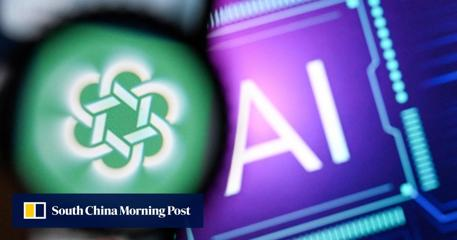

[Filipino journalist counters industry’s AI doomsday fears with custom chatbot assistant to aid in-depth reporting](https://www.scmp.com/week-asia/people/article/3256522/filipino-journalist-upends-industrys-ai-doomsday-fears-custom-chatbot-aid-depth-reporting) - South China Morning Post

___

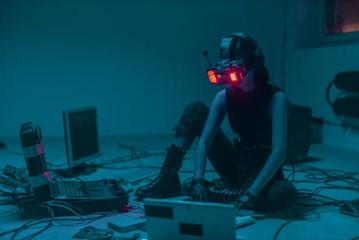

[Four generative AI cyber risks that keep CISOs up at night — and how to combat them](https://siliconangle.com/2024/03/24/four-generative-ai-cyber-risks-keep-cisos-night-combat/) - SiliconANGLE

___

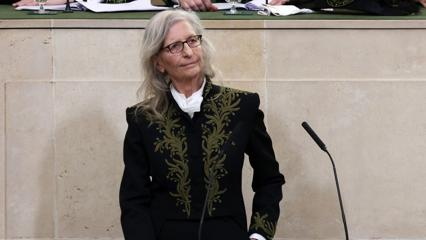

[Annie Leibovitz on AI: photography is not really real either](https://www.digitalcameraworld.com/tutorials/photography-itself-is-not-really-real-i-use-all-the-tools-available-says-annie-leibovitz-in-her-lacademie-des-beaux-arts-induction) - digitalcameraworld

___

Error fetching https://www.makeuseof.com/codeiums-free-ai-anyone-write-code/: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


[Codeium as a free alternative to GitHub Copilot](https://www.makeuseof.com/codeiums-free-ai-anyone-write-code/)

___

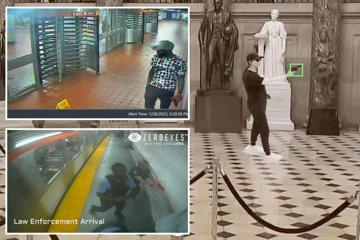

[AI to detect guns in subways. Maybe use AI to detect gross smells, gropers, creeps whipping it out, fights breaking out while we're at it.](https://nypost.com/2024/03/23/us-news/nypd-looks-at-possible-ai-to-see-guns-underground/) - New York Post

___

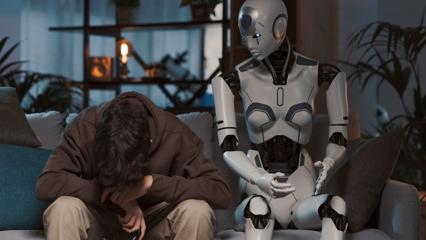

[Huang says fully generated AI games by 2030](https://www.techradar.com/computing/gpu/fully-ai-generated-games-by-2030-thats-what-nvidias-ceo-believes-but-what-exactly-will-that-mean-for-pc-gamers) - TechRadar

___

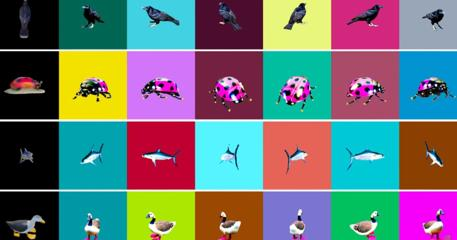

[Nividia makes games 3D models from text prompts](https://www.digitaltrends.com/computing/nvidia-unveils-latte3d-generative-ai/) - Digital Trends

___

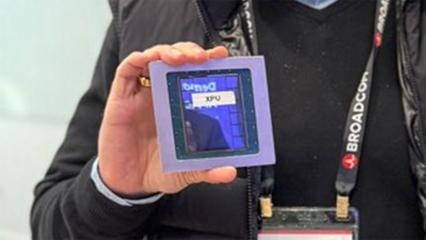

[Unusually large, ugly custom chip born](https://www.tomshardware.com/tech-industry/artificial-intelligence/broadcom-shows-gargantuan-ai-chip-xpu-could-the-worlds-largest-chip-built-for-a-consumer-ai-company) - Tom's Hardware

___

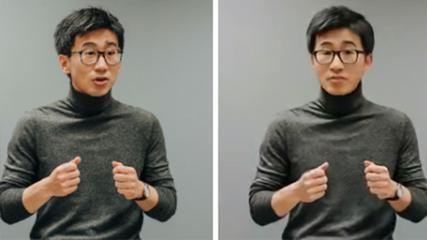

[Google researchers create Vlogger, a novel way of turning a single photo of a human and a few seconds of voice into AI-generated video good enough to make you think 'this might go badly'](https://www.pcgamer.com/software/ai/google-researchers-find-novel-way-of-turning-a-single-photo-of-a-human-into-ai-generated-video-good-enough-to-make-you-think-this-might-go-badly/) - pcgamer

___

[6 big questions about AI - Niall Ferguson](https://www.bloomberg.com/opinion/articles/2024-03-24/can-sam-altman-make-ai-smart-enough-to-answer-these-6-questions)

___

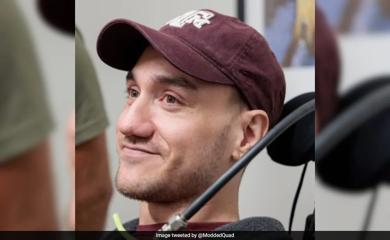

[Local man tweets using brain-computer interface](https://www.ndtv.com/world-news/man-with-elon-musks-neuralink-brain-chip-posts-tweet-on-x-just-by-thinking-5300011) - NDTV.com

___

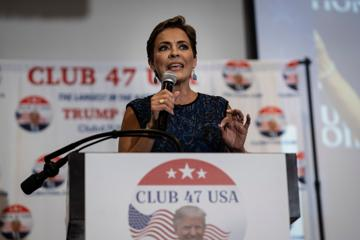

[Arizona blog posts deepfake endorsement from Kari Lake, she is mad and some readers may be unsubscribing because they think it's real](https://www.washingtonpost.com/politics/2024/03/24/kari-lake-deepfake/) - Washington Post

___

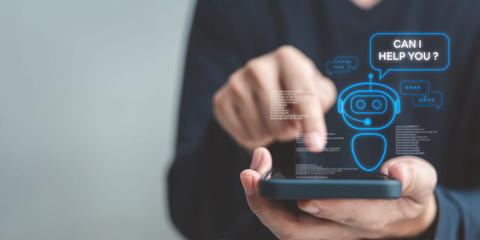

[How hard is it to spam data into LLMs for propaganda or marketing purposes?](https://www.businessinsider.com/data-poisoning-ai-chatbot-chatgpt-large-language-models-florain-tramer-2024-3) - Business Insider

___

[AI could make MTA safer but sometimes I think subways are just run as a rat habitat and a Milgram experiment by the NYPD and dumping ground for psychiatric homeless. The mayor is a cop but all the NYPD does is complain about politicians and can't be arsed to fight crime.](https://twitter.com/macc_nyc/status/1771242879840575886)

___

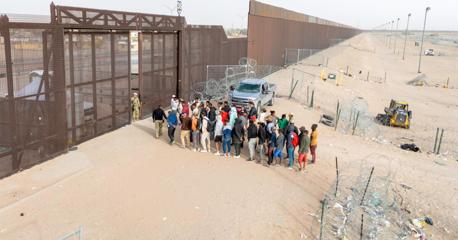

[The Future of Border Patrol: AI Is Always Watching](https://themarkup.org/news/2024/03/22/the-future-of-border-patrol-ai-is-always-watching)

___

this brings me joy

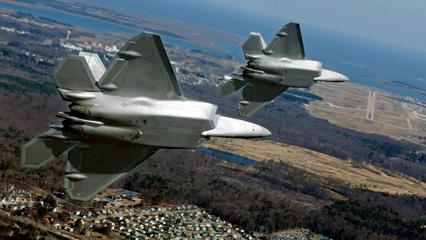

[Can't remember if I shared, spy drone scare triggered a military scramble, including calling in NASA](https://www.twz.com/air/mysterious-drones-swarmed-langley-afb-for-weeks) - The War Zone

___

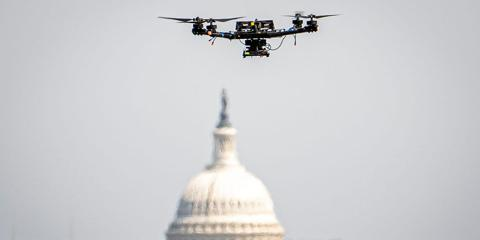

[Autonomous drone swarms are an emerging threat and something US military wants to field](https://www.businessinsider.com/swarms-drones-rising-threat-to-us-law-enforcement-isnt-ready-2024-3) - Business Insider

___

[Will all the LLMs and edge devices unite to create The Borg?](https://techxplore.com/news/2024-03-scientists-future-artificial-intelligence-similar.html)

___

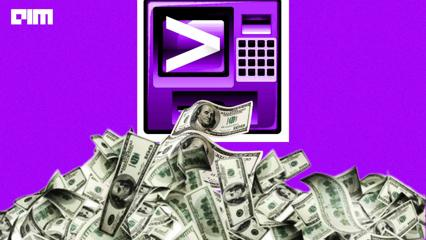

[Accenture sells $1.1b worth of AI projects](https://analyticsindiamag.com/accentures-generative-ai-revenue-surpasses-all-vc-backed-startups-combined/) - Analytics India Magazine

___

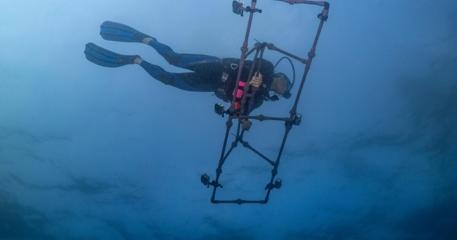

[Using GoPro videos and AI to monitor ocean health](https://newatlas.com/science/deepreefmap-video-footage-3d-coral-reef-maps/) - New Atlas

___

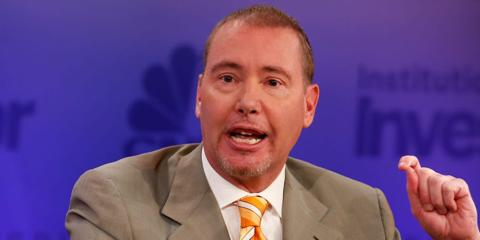

[Famous investors who are calling the b-word](https://www.businessinsider.com/stock-market-bubble-crash-gundlach-ai-fed-economy-gross-hussman-2024-3) - Business Insider

___

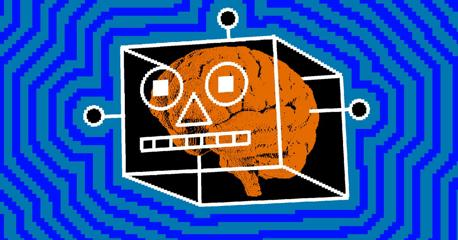

[Financial Times launches a sepia-colored AI chatbot](https://www.theverge.com/2024/3/23/24106296/ask-ft-generative-ai-chatbot-answers-tool) - The Verge

___

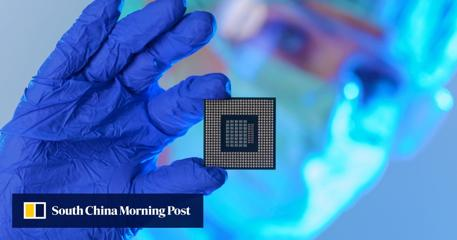

[Ultra-low-power AI chips for always-on listening](https://www.scmp.com/news/china/science/article/3256211/chinese-scientists-create-worlds-most-energy-efficient-ai-chips-mobile-devices) - South China Morning Post

___

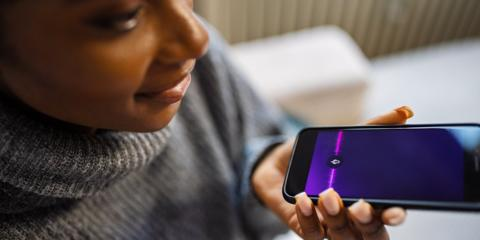

[Apple considering dropping 'hey Siri' in favor of LLM approach](https://www.technologyreview.com/2024/03/22/1090090/apple-researchers-explore-dropping-siri-phrase-amp-listening-with-ai-instead/) - MIT Technology Review

___

[How to make a self-driving car hit you for fun and profit](https://www.sfgate.com/tech/article/self-driving-cars-asian-art-museum-19364136.php)

___

[Coreweave looking to raise equity to build AI cloud data centers at $16b valuation](https://www.bloomberg.com/news/articles/2024-03-22/coreweave-is-in-talks-for-funding-at-16-billion-valuation)

___

I have to say, Gmail is crazy slow for some operations since opting into AI features, use caution.

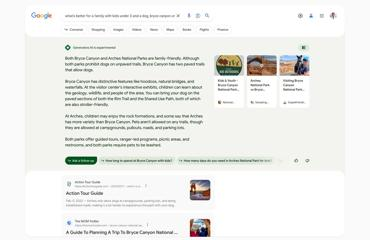

[Google will start showing AI answers to users who didn't opt in. They are presumably excluding high-stakes queries like money, health.](https://www.engadget.com/google-will-start-showing-ai-powered-search-results-to-users-who-didnt-opt-in-093036257.html) - Engadget

___

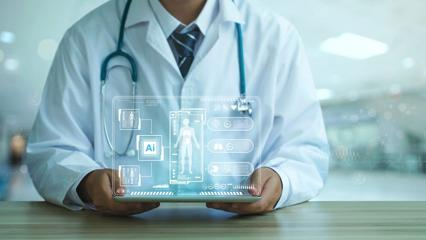

[Google redesigns how it deals with health questions](https://www.zdnet.com/article/google-just-gave-search-results-for-health-conditions-an-ai-facelift-heres-whats-new/) - ZDNET

___

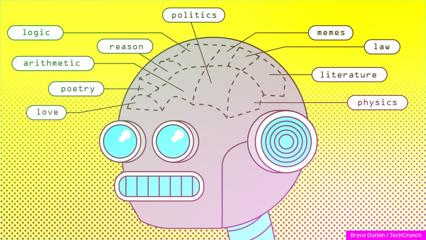

[AI is too complex for static benchmarks, there is memorization, training to the test, safety, bias, and above all it's super subjective](https://techcrunch.com/2024/03/23/why-its-impossible-to-review-ais-and-why-techcrunch-is-doing-it-anyway/) - TechCrunch

___

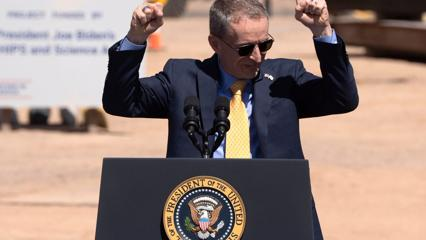

[It ain't $6 trillion but Intel is building AI chips with about $40b in industrial policy assistance](https://qz.com/intel-ai-chip-factory-world-chips-act-funds-1851358125) - Quartz

___

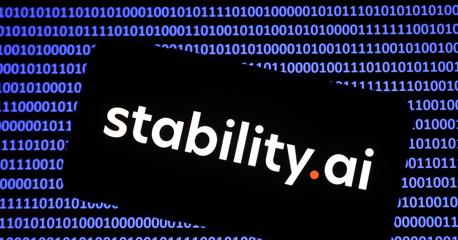

[Stability AI CEO resigns, totally his own decision, just wants to do something different](https://www.theverge.com/2024/3/23/24109511/stability-ai-ceo-emad-mostaque-resignation-decentralized-ai) - The Verge

___

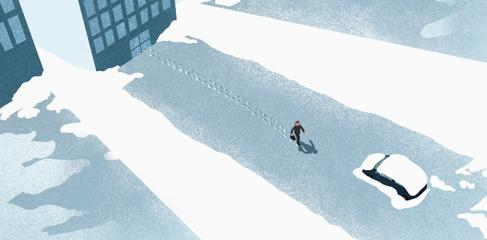

[The unsuccessful search for the first victim of the Eliza effect, Weizenbaum's assistant, who turned the anti-Pygmalion against his creation](https://theconversation.com/my-search-for-the-mysterious-missing-secretary-who-shaped-chatbot-history-225602) - The Conversation

___

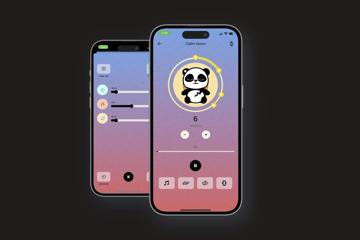

[Like it or not, AI mental health, coaching, self-help chatbots are here](https://thegrio.com/2024/03/23/ai-chatbots-used-to-help-with-mental-health-struggles/) - TheGrio

___

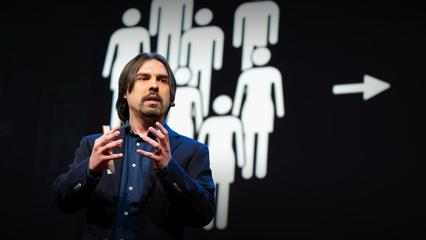

[César Hidalgo TED talk about replacing political decisionmaking with popular preferences, systems and AI](https://www.ted.com/talks/cesar_hidalgo_a_bold_idea_to_replace_politicians?rss=172BB350-0207)

___

[Want to Know if AI Will Take Your Job? I Tried Using It to Replace Myself](https://www.wsj.com/tech/ai/jobs-chatgpt-artificial-intelligence-openai-cea961d5)

___

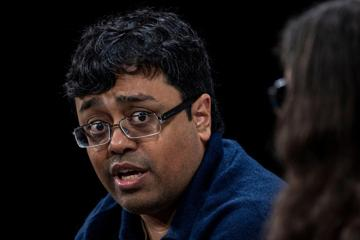

[Stability AI CEO Mostaque reportedly told industry sources he will be stepping down](https://www.forbes.com/sites/kenrickcai/2024/03/22/stability-ai-founder-emad-mostaque-plans-to-resign-as-ceo-sources-say/?sh=eaa95f452392) - Forbes

___

US-based big tech is winning the global talent war

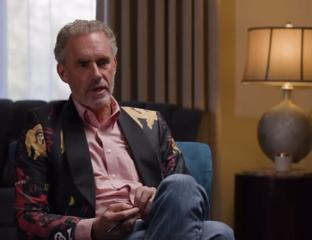

[Maybe we need an AI to distinguish artificial intellegence problems from natural stupidity problems.](https://www.mediaite.com/news/jordan-peterson-proposes-using-ai-to-determine-whether-hitler-was-right-wing-because-he-cant-figure-it-out-himself/) - Mediaite

___

[China has more ML researcherrs than US](https://www.nytimes.com/2024/03/22/technology/china-ai-talent.html)

___

[Apple talked to Baidu about using their AI, WSJ reported](https://www.reuters.com/technology/apple-held-talks-with-chinas-baidu-over-ai-use-its-devices-wsj-reports-2024-03-22/)

___

name 'httplib' is not defined


[An LLM for data science, probably better than my ChatGPT assistant for data science LOL](https://arxiv.org/abs/2402.18679v3) - arXiv.org

___

[There is a 'leak' going around about Q-Star being an energy-based model, but it might just be AI-generated](https://twitter.com/jeremyphoward/status/1770635047722438733)

___

[But if you want to sell, there is a target-rich environment of bigcos that need LLM plays](https://www.bloomberg.com/news/articles/2024-03-22/tech-giants-seek-partnerships-talent-to-speed-up-ai-deployment)

___

[The chatbot market got crowded fast and there is already a shakeout underway](https://www.bloomberg.com/news/newsletters/2024-03-21/inflection-ai-upheaval-a-wake-up-call-for-crowded-chatbot-market)

___

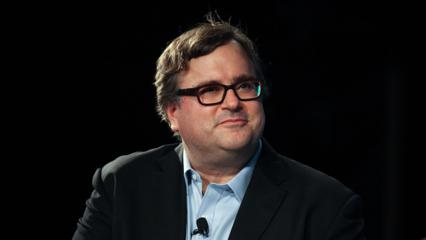

[Some leaks on how Microsoft is paying off investors in Inflection. Sounds like they are 'buying' it at 1/2 the last valuation, the founders took the hit to make VCs whole](https://techcrunch.com/2024/03/21/microsoft-inflection-ai-investors-reid-hoffman-bill-gates/) - TechCrunch

___

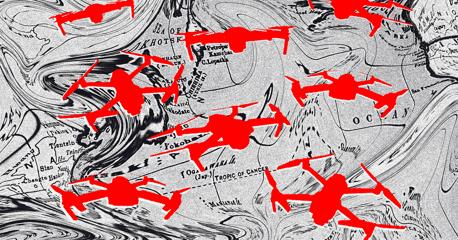

[Pentagon wants thousands of autonomous drones, like yesterday](https://www.vox.com/world-politics/24107959/replicator-drones-china-taiwan-ukraine-pentagon) - Vox

___

Between some new prompt-fu in the GPT Store, and latest OpenAI updates, you can now generate ludicrously realistic images from the integrated Dall-E

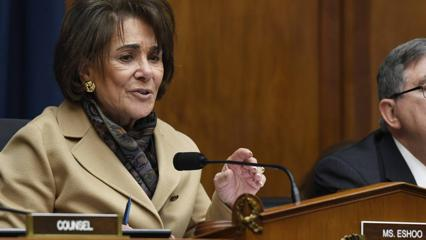

[We need the good actors to label when they use AI but we also need crypto-assured chains of provenance. If you get a photo of Kate Middleton, there should be a 'git blame' trail showing when it was digitally signed by the camera and every change thereafter.](https://www.whio.com/news/new-bipartisan-bill/7U5ZZVC2MP6KPDHAUUSMXU7KYU/) - WHIO TV 7 and WHIO Radio

___

In [45]:
imgdir = 'tmp'
delete_files(imgdir)

display(Markdown(f"Follow latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))


for i, post in enumerate(data.feed):
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = get_og_tags(post_url)
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

In [46]:
data.feed[0].post.record.embed.external.thumb.dict()

{'mime_type': 'image/jpeg',
 'size': 235094,
 'ref': {'link': 'bafkreiexoxs5zwlgftfbmtmvf7q3nwvxmjcd2txwep7d6bmlca5ezlpu2a'},
 'py_type': 'blob'}

In [47]:
data.feed[0].post.record.embed.dict()

{'external': {'description': 'Jaemark Tordecilla has created an AI tool to help investigative reporters uncover wrongdoing in Philippine government audit reports, in what could mark a sea change for journalism in the Global South.',
  'title': 'Filipino journalist’s AI tool for in-depth reporting challenges industry fears',
  'uri': 'https://www.scmp.com/week-asia/people/article/3256522/filipino-journalist-upends-industrys-ai-doomsday-fears-custom-chatbot-aid-depth-reporting',
  'thumb': {'mime_type': 'image/jpeg',
   'size': 235094,
   'ref': {'link': 'bafkreiexoxs5zwlgftfbmtmvf7q3nwvxmjcd2txwep7d6bmlca5ezlpu2a'},
   'py_type': 'blob'},
  'py_type': 'app.bsky.embed.external#external'},
 'py_type': 'app.bsky.embed.external'}

In [48]:
print(datetime.now())

2024-03-25 07:53:23.164087
